# **KF on existing predictions**

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 10,10

import json
import os

from filterpy.kalman import KalmanFilter

#### Path setup

In [2]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [3]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(datasets_path, all_datasets[1], "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(datasets_path, all_datasets[1], "info_eval.csv"))
eval_info = eval_info.drop([0]) # First route  does not work
eval_info['cumsum'] = eval_info['cumsum'] - 2

In [4]:
def plot_route_df(route):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    plt.plot(route['gt_pc1centers_x'], route['gt_pc1centers_y'], '-ok',color='black')
    plt.plot(route['gt_pc1centers_x']+route['pred_trans_x'], route['gt_pc1centers_y']+route['pred_trans_y'], '-ok', color='orange')

#### Split into different route/tables

In [5]:
predictions

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,gt_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y
0,-1.161620,0.113711,-0.009960,-1.276125,0.078547,-0.002452,25.918905,16.165125
1,-1.313605,0.083020,-0.001869,-1.276123,0.078548,-0.002451,24.642780,16.243671
2,-1.032394,0.137887,-0.007751,-1.276123,0.078547,-0.002452,23.366657,16.322220
3,-1.164084,-0.023347,-0.003965,-1.276123,0.078548,-0.002452,22.090534,16.400766
4,-1.221428,0.088355,-3.084884,-1.276123,0.078547,-0.002452,20.814411,16.479315
...,...,...,...,...,...,...,...,...
12065,-2.298328,0.101079,-0.047249,-1.754080,0.017648,-0.005763,15.719444,6.739439
12066,-1.782889,-0.011886,-0.050040,-1.754082,0.017648,-0.005763,13.965364,6.757087
12067,-1.914164,0.041815,-0.006580,-1.754080,0.017648,-0.005763,12.211283,6.774735
12068,-1.648375,0.061937,0.007021,-1.754081,0.017648,-0.005763,10.457203,6.792383


In [6]:
eval_info

,name,type,first_point,n_points,cumsum
1,2_1,E,28465,6,0
2,2_2,E,28471,10,6
3,2_4,E,28481,92,16
4,2_5,E,28573,34,108
5,2_6,E,28607,83,142
...,...,...,...,...,...
232,18_16,E,40419,25,11954
233,18_17,E,40444,18,11979
234,18_18,E,40462,16,11997
235,18_19,E,40478,40,12013


In [7]:
def routes_to_dict(eval_info, predictions):
    routes = dict()
    n_routes = eval_info.shape[0]
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        end_i = start_i + current['n_points']
        current_pred = predictions.iloc[start_i:end_i]
        
        routes[current['name']] = current_pred
            
    return routes

In [8]:
routes = routes_to_dict(eval_info, predictions)

#### Plot single tables

In [9]:
i = 10

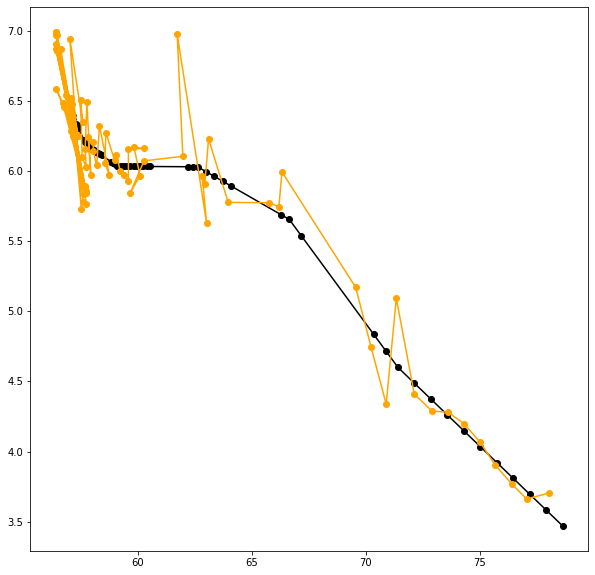

In [10]:
plot_route_df(routes[list(routes.keys())[i]])
i += 1

#### Run simple evaluation

In [11]:
def compute_error_route(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'error_x'] = (route['pred_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'error_y'] = (route['pred_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'error_angle'] = ((route['pred_angles']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['error_x'])
    y_e = np.mean(route['error_y'])
    a_e = np.mean(route['error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [12]:
def compute_error(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        trans, angle = compute_error_route(route)
        error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['error_trans'], eval_info['error_angle'] = error[:,0], error[:,1]
    # Remember that -2 in the routes index? The first route had 0 points so
    # it is a NaN. TODO: Investigate this
    #eval_info = eval_info.drop([0], axis=0)
    
    trans_error = np.mean(eval_info['error_trans'])
    angle_error = np.mean(eval_info['error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [13]:
compute_error(eval_info, routes)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


RMSE trans: 0.17511024171409081
RMSE angle: 197.21943474117137


(0.17511024171409081, 197.21943474117137)

#### Run KF on single table

In [17]:
def run_kf_predictions(route):
    """ Runs Kalman Filter on the predictions 
        Params:
        -
        -
    """
    # Tracker object initialization
    position = route.iloc[0,0:3].values
    tracker = KalmanMotionTracker(position)
    
    # Container for the KF data
    kf = np.zeros((route.shape[0],3))
    kf[0,:] = route.iloc[0,0:3]
    # We feed from 0 to N observations to the filter
    for i in range(1, route.shape[0]):
        position = route.iloc[i,0:3].values
        tracker.update(position)
        # We store the inmediate pose
        #predictions = tracker.predict().ravel()
        predictions = tracker.get_state()
        kf[i,:] = predictions[:3]
        
    return kf

In [18]:
for i in range(len(routes)):
    
    route = routes[list(routes.keys())[i]]
    
    kf_pred = run_kf_predictions(route)
    
    route[['kf_trans_x','kf_trans_y', 'kf_angle']] = pd.DataFrame(kf_pred, index=route.index)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:2960: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [76]:
def create_arrow(posx, posy, angle, color):
    return patches.FancyArrow(posx, posy, 0.5*math.cos(angle), 0.5*math.sin(angle), width=0.01, head_width=0.05, head_length=0.06, color=color)

In [77]:
def plot_route_df_kf(name, routes, eval_info):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    route = routes[name]
    route_info = eval_info.loc[eval_info['name'] == name]
    nn_rmse = route_info['error_trans'].values[0]
    kf_rmse = route_info['kf_error_trans'].values[0]
    
    fig, ax = plt.subplots()
    
    # Add the data points
    gt = [route['gt_pc1centers_x'], route['gt_pc1centers_y']]
    pr = [gt[0]+route['pred_trans_x'], gt[1]+route['pred_trans_y']]
    kf = [gt[0]+route['kf_trans_x'], gt[1]+route['kf_trans_y']]
    
    ax.plot(gt[0], gt[1], '-ok',color='black')
    ax.plot(pr[0], pr[1], '-ok', color='orange')
    ax.plot(kf[0], kf[1], '-ok', color='red')
    
    # Add the arrows
    for posx, posy in zip(gt[0], gt[1]):
        ax.add_patch(create_arrow(posx, posy, math.pi/3, 'black'))
    for posx, posy in zip(pr[0], pr[1]):
        ax.add_patch(create_arrow(posx, posy, math.pi/4, 'orange'))
    for posx, posy in zip(kf[0], kf[1]):
        ax.add_patch(create_arrow(posx, posy, math.pi/2, 'red'))

    
    # Set title to the plot
    ax.set_title(f"route: {name} nn_rmse: {nn_rmse} kf_rmse: {kf_rmse}", size=20)
   

In [79]:
route

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,gt_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y,error_x,error_y,error_angle,kf_trans_x,kf_trans_y,kf_angle,kf_error_x,kf_error_y,kf_error_angle
12053,-1.861742,0.071582,0.077510,-1.721062,0.088367,-0.000085,37.482900,5.949889,0.019791,0.000282,195.079210,-1.861742,0.071582,0.077510,1.979081e-02,2.817508e-04,195.079210
12054,-1.671552,0.055787,-0.006870,-1.721062,0.088368,-0.000086,35.761837,6.038256,0.002451,0.001062,1.491374,-1.688842,0.057222,0.000800,1.038100e-03,9.700428e-04,0.025457
12055,-1.754349,0.059339,-0.005176,-1.874142,0.058147,-0.000145,34.040775,6.126624,0.014350,0.000001,0.820119,-1.720036,0.058230,-0.002046,2.374868e-02,6.935844e-09,0.117034
12056,-1.855146,0.137619,-0.051869,-1.874147,0.058148,-0.000146,32.166634,6.184771,0.000361,0.006316,86.678970,-1.763620,0.083839,-0.018118,1.221637e-02,6.600504e-04,10.464521
12057,-1.787397,0.063543,-0.053244,-1.874144,0.058147,-0.000145,30.292486,6.242919,0.007525,0.000029,91.350624,-1.769419,0.078889,-0.026685,1.096724e-02,4.302308e-04,22.821470
12058,-1.819973,0.053684,-3.029510,-1.874146,0.058148,-0.000145,28.418343,6.301066,0.002935,0.000020,297336.561662,-1.779332,0.073947,-3.141068,8.989683e-03,2.496032e-04,319638.952265
12059,-1.861105,0.089702,-0.002965,-1.874144,0.058148,-0.000146,26.544197,6.359214,0.000170,0.000996,0.257393,-1.792737,0.076530,-0.000048,6.627017e-03,3.378709e-04,0.000314
12060,-1.774456,0.061369,-3.079024,-1.790123,0.064415,0.004936,24.670053,6.417362,0.000245,0.000009,308150.300460,-1.790162,0.074394,-3.132821,1.543604e-09,9.958862e-05,318994.864956
12061,-1.636513,0.041069,-0.049673,-1.790121,0.064415,0.004937,22.879930,6.481777,0.023595,0.000545,96.625005,-1.771193,0.070280,0.001556,3.582634e-04,3.440025e-05,0.370327
12062,-1.544044,0.054829,0.003732,-1.790121,0.064416,0.004936,21.089810,6.546192,0.060554,0.000092,0.046961,-1.746232,0.068582,0.001795,1.926273e-03,1.735828e-05,0.319601


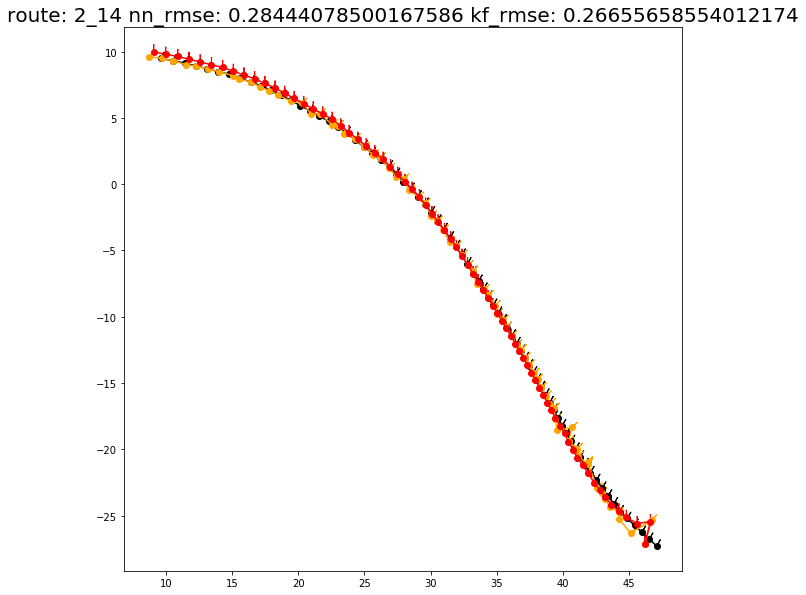

In [78]:
plot_route_df_kf(list(routes.keys())[11], routes, eval_info)
i += 1

#### Run simple evaluation again

In [22]:
def compute_error_route_kf(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'kf_error_x'] = (route['kf_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'kf_error_y'] = (route['kf_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'kf_error_angle'] = ((route['kf_angle']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['kf_error_x'])
    y_e = np.mean(route['kf_error_y'])
    a_e = np.mean(route['kf_error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [23]:
def compute_error_kf(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        # This is bc there are some routes without the kf columns
        if route.shape[0] == 0:
            error[i,:] = [np.nan, np.nan]
        else:
            trans, angle = compute_error_route_kf(route)
            error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['kf_error_trans'], eval_info['kf_error_angle'] = error[:,0], error[:,1]
    
    
    trans_error = np.mean(eval_info['kf_error_trans'])
    angle_error = np.mean(eval_info['kf_error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [24]:
compute_error_kf(eval_info, routes)

RMSE trans: 0.18568471524753094
RMSE angle: 276.2050700614799


(0.18568471524753094, 276.2050700614799)

#### Kalman filter implementation

In [16]:
class KalmanMotionTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as translation.
    """
    def __init__(self, position):
        """
        Initialises a tracker using initial position.

        KF Instance variables:
          x : ndarray (dim_x, 1), default = [0,0,0…0] filter state estimate
          P : ndarray (dim_x, dim_x), default eye(dim_x) covariance matrix
          Q : ndarray (dim_x, dim_x), default eye(dim_x) Process uncertainty/noise
          R : ndarray (dim_z, dim_z), default eye(dim_x) measurement uncertainty/noise
          H : ndarray (dim_z, dim_x) measurement function
          F : ndarray (dim_x, dim_x) state transistion matrix
          B : ndarray (dim_x, dim_u), default 0 control transition matrix
        """
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=5, dim_z=3)   

        self.kf.x[:3] = position.reshape((3, 1))
        self.kf.P[3:,3:] *= 1000. #state uncertainty, give high uncertainty to the unobservable initial velocities, covariance matrix
        self.kf.P *= 10.
        self.kf.Q[3:,3:] *= 0.01


        self.kf.F = np.array([[1,0,0,1,0],      # state transition matrix
                              [0,1,0,0,1],
                              [0,0,1,0,0],
                              [0,0,0,1,0],  
                              [0,0,0,0,1]])

        self.kf.H = np.array([[1,0,0,0,0],      # measurement function,
                              [0,1,0,0,0],
                              [0,0,1,0,0]])


        # self.kf.R[0:,0:] *= 10.   # measurement uncertainty

        self.time_since_update = 0
        self.history = []
        self.hits = 1           # number of total hits including the first detection
        self.hit_streak = 1     # number of continuing hit considering the first detection
        self.first_continuing_hit = 1
        self.still_first = True
        self.age = 0

    def update(self, position): 
        """ 
        Updates the state vector with observed position.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1          # number of continuing hit
        if self.still_first:
            self.first_continuing_hit += 1      # number of continuing hit in the fist time

        ######################### orientation correction NEEDED?
        if self.kf.x[2] >= np.pi: self.kf.x[2] -= np.pi * 2    # make the theta still in the range
        if self.kf.x[2] < -np.pi: self.kf.x[2] += np.pi * 2

        new_theta = position[2]
        if new_theta >= np.pi: new_theta -= np.pi * 2    # make the theta still in the range
        if new_theta < -np.pi: new_theta += np.pi * 2
        position[2] = new_theta

        predicted_theta = self.kf.x[2]
        if abs(new_theta - predicted_theta) > np.pi / 2.0 and abs(new_theta - predicted_theta) < np.pi * 3 / 2.0:     # if the angle of two theta is not acute angle
            self.kf.x[2] += np.pi       
            if self.kf.x[2] > np.pi: self.kf.x[3] -= np.pi * 2    # make the theta still in the range
            if self.kf.x[2] < -np.pi: self.kf.x[3] += np.pi * 2

        # now the angle is acute: < 90 or > 270, convert the case of > 270 to < 90
        if abs(new_theta - self.kf.x[2]) >= np.pi * 3 / 2.0:
            if new_theta > 0: self.kf.x[2] += np.pi * 2
            else: self.kf.x[2] -= np.pi * 2

        #########################

        self.kf.update(position)

        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2    # make the theta still in the range
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

    def predict(self):       
        """
        Advances the state vector and returns the predicted movement estimate.
        """
        self.kf.predict()      
        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
            self.still_first = False
        self.time_since_update += 1
        self.history.append(self.kf.x)
        
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return self.kf.x[:3].reshape((3, ))